In [1]:
### Notebook for P3D stuff!
import os 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import jax
jax.config.update('jax_platform_name', 'gpu')
from jax.lib import xla_bridge
print("jax version",jax.__version__)
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp

%pylab inline

jax version 0.5.0


/tmp/ipykernel_100240/3036284989.py:10: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


gpu
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [131]:
#from jaxpm.kernels import *
#uses jaxpm for some kernels... maybe?

In [3]:
#First things... set the redshift

z= 2.0

#set box geometry, probably should wrap this into the fiducial model file (hdf5?) to lead to less fiddling bugs

bs =  128#box size in Mpc/h
nc =  128#number of pixels per side

mesh_shape = [nc,nc,nc]
box_size = [bs,bs,bs]

ptcl_grid_shape = (nc,) * 3
ptcl_spacing = bs/nc



In [4]:
#some fourier space routines
from helper_functions import *

kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))
#this vector is needed for lots of fourier space transformation operations later on...
print(k.shape)

/tmp/ipykernel_100240/2721841557.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))


(128, 128, 65)


In [49]:
#in this setup, LOS (z) is along the 0 axis, be careful when loading in data!

kz = jnp.ones(k.shape)*kvec[0]**2

kx = jnp.ones(k.shape)*(kvec[1]**2+kvec[2]**2)
#tiny deltas are added to avoid div by zero errors
kk = (kx+kz)+10**(-8)
kmu = (kz/(k**2+0.00001))


In [50]:
tau = np.load("/gpfs02/work/diffusion/P3D/data/CROL200_deltaf_bf50_red_zoom150.npy")

In [51]:
from scipy import ndimage
tau_new = ndimage.zoom(tau,128/150)

In [52]:
tau_new.shape

(128, 128, 128)

In [53]:

#data = tau_new-tau_new.min()#np.load("example_field.npy")
d_f = tau_new#np.exp(-1*data)
import powerspectra

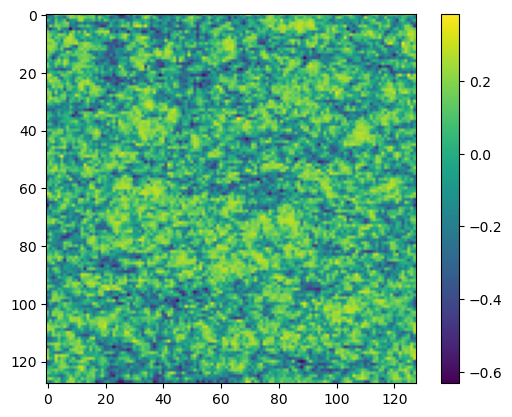

In [54]:
imshow(tau_new[30])
colorbar()

In [58]:
k_array, pk = powerspectra.power_spectrum((d_f),kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))

In [60]:

func = jax.nn.relu(jnp.interp(np.sqrt(kk),k_array/(2*np.pi),pk,left=pk[0],right=pk[-1]))
func = func.reshape(128,128,65)

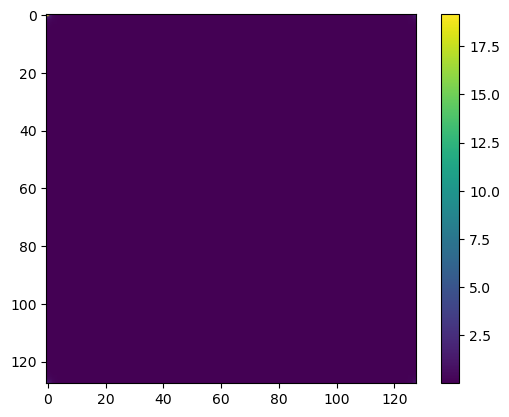

In [61]:
imshow(func[:,:,0])
colorbar()

In [62]:

import powerspectra

In [63]:
np.sqrt(kk.min())

np.float32(1e-04)

In [64]:
#sampling the tiniest modes doesn't really help very much and makes the optimization much more sensitive
#here we set the modes after 18 to be equal to the fiducial model, could also play around with zeroing them out

def power_b(theta):#,tff=tff):
   # tff = tff.at[:,:k_ind_optim_max].set(theta.reshape(4,k_ind_optim_max))
    
    func = jax.nn.relu(jnp.interp(jnp.sqrt(kk),k_array,theta,left=theta[0],right=theta[-1]))
    return func.reshape(128,128,65)



In [65]:
#muse componenet...
from functools import partial
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem

In [66]:

#file name
prefix = "V1_DENSE_"
loc = "./configs/"

naa = np.load(loc+prefix+"naa.npy")
kernel = np.load(loc+prefix+"kernel.npy")
skewers_skn = np.load(loc+prefix+"skewers_skn.npy")
skewers_dla = np.load(loc+prefix+"skewers_dla.npy")
skewers_fin = np.load(loc+prefix+"skewers_fin.npy")


from jax import jit
@jit
def cic_readout_jit_jnc(mesh,naa,kernel,bs=False):
    #"highly optimized" CIC, need to preprocess lots of things... don't diff output coords
    meshvals = mesh.flatten()[naa].reshape(-1,8).T#mesh[tuple(neighboor_coords[0,:,:].T.tolist())]
    weightedvals = meshvals.T* kernel[0]
    values = np.sum(weightedvals, axis=-1)
    
    return values



In [67]:
tf_cut_flat = pk.flatten()

noise_level = 1.0

def gen_map_lya(theta,z):
    modes = z[:nc**3].reshape((nc,nc,nc))    
    Plin = power_b(theta)
    conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
    lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

    lya_values = cic_readout_jit_jnc(lin_modes_real,naa,kernel)
    return lya_values
                 
def gen_map_sim(sim):
    lya_values = cic_readout_jit_jnc(sim,naa,kernel)
    return lya_values
    
class Jax3DMuseProblem_flat(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    #@jax.jit
    def sample_x_z(self, key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nc*nc*nc,))
        x = gen_map_lya(θ,z) + (1.0*skewers_skn)*jax.random.normal(keys[1], (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
   #     print(z.shape,x.shape)
        return (x, z)

  #  @jax.jit
    def logLike(self, x, z, θ):
        return -(jnp.sum((x - gen_map_lya(θ,z))**2/((1*skewers_skn)**2))+ jnp.sum(z**2.0))

  #  @jax.jit
    def logPrior(self, θ):
        return -jnp.sum(((θ-jnp.array(tf_cut_flat)*1.1)**2 / (2*(tf_cut_flat*0.4)**2)))
    


In [68]:
prob = Jax3DMuseProblem_flat(implicit_diff=True,jit=False)
key = jax.random.PRNGKey(100)
if False: #debug
    (x, z) = prob.sample_x_z(key, tf_cut_flat)
    prob.set_x(x)
else:
    z = jax.random.normal(key, (nc*nc*nc,))
    d_f = tau_new#np.exp(-1*data)
    siml = gen_map_sim((d_f)) 
    x = siml + (1*skewers_skn)*jax.random.normal(key, (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
    prob.set_x(x)
rng = jax.random.PRNGKey(1)
x_data = x

In [69]:
modes = z[:nc**3].reshape((nc,nc,nc))
Plin  = power_b(tf_cut_flat.flatten())  # this is P(k,mu)
amp_fac = jnp.sqrt((nc**3) / (bs**3))

conv_field = jnp.fft.rfftn(modes) * (Plin**0.5)
lin_modes_real = jnp.fft.irfftn(conv_field)[:,:,:]


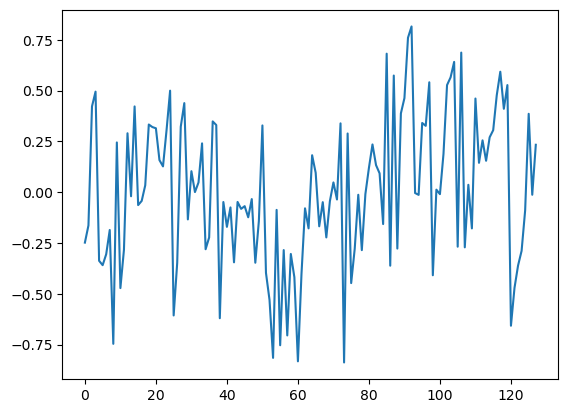

In [70]:
plt.plot(x.reshape(-1,128)[20])

In [71]:
k_array, pk = powerspectra.power_spectrum(tau_new,kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))
k_arrayl, pkl = powerspectra.power_spectrum(lin_modes_real,kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))


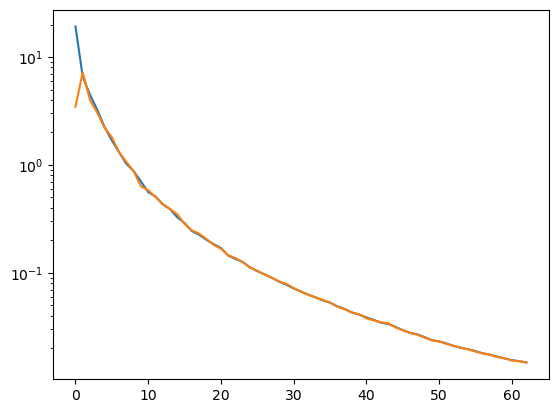

In [73]:
plt.semilogy(pk)
plt.semilogy(pkl)

In [74]:
from numpy.random import SeedSequence, default_rng
from copy import copy

start_point = np.abs(jnp.array(tf_cut_flat)*1.2)#+np.random.randn(len(tf_cut_flat))*jnp.array(tf_cut_flat)*0.01)

def _split_rng(rng, N):
    keyz = []
    for i in range(N):
        rng, subkey = jax.random.split(rng)
        keyz.append(rng)
    return keyz
    
θ = start_point

maxsteps = 200
nsims=5
rng = jax.random.PRNGKey(1)

xz_sims = [prob.sample_x_z(_rng, θ) for _rng in _split_rng(rng, nsims)]
xs = [x_data] + [x for (x,_) in xz_sims]
ẑs = [z*0]     + [z*0 for (x, z) in xz_sims]

In [75]:
from jax import grad, hessian, jacfwd, jvp, value_and_grad, vmap

def gradθ_hessθ_logPrior(θ, transformed_θ=None):
        g = grad(prob.logPrior)(θ)
        H = hessian(lambda θ_vec: prob.logPrior(unravel_θ(θ_vec)))(ravel_θ(θ))
        return (g, H)

step: 1 0.5


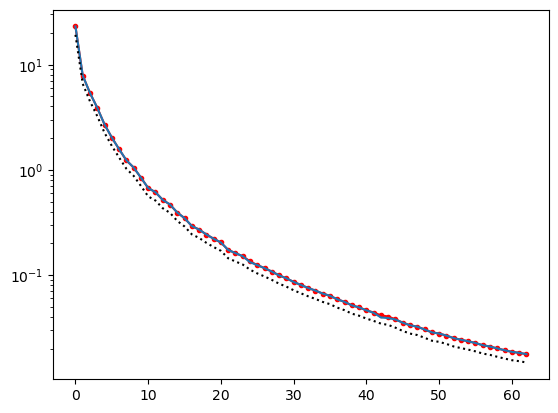

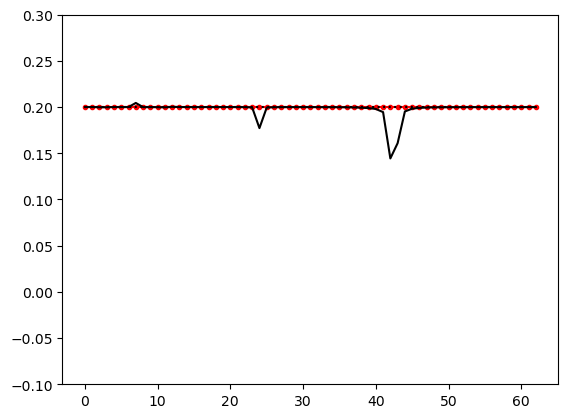

step: 2 0.475


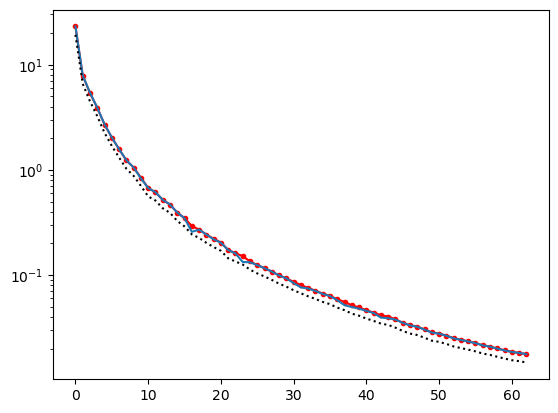

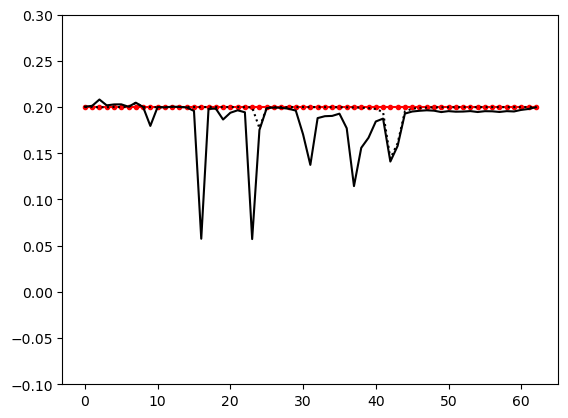

step: 3 0.45125


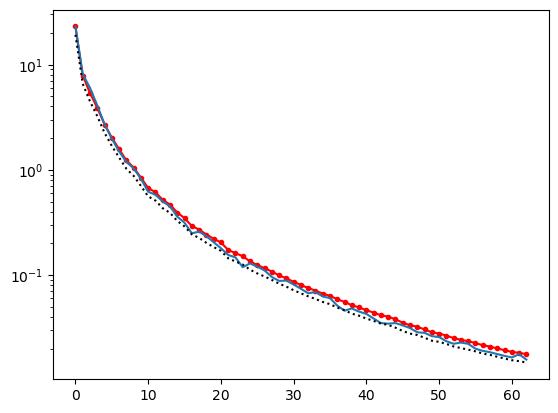

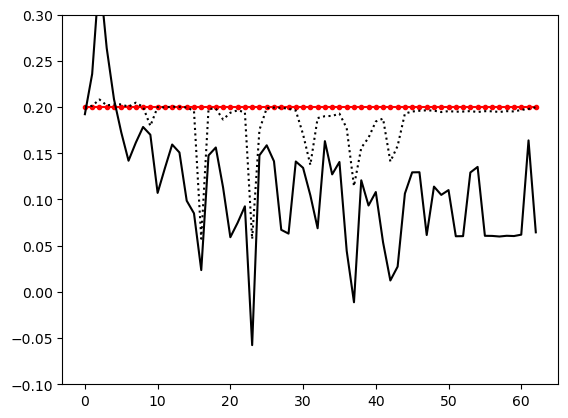

step: 4 0.42868749999999994


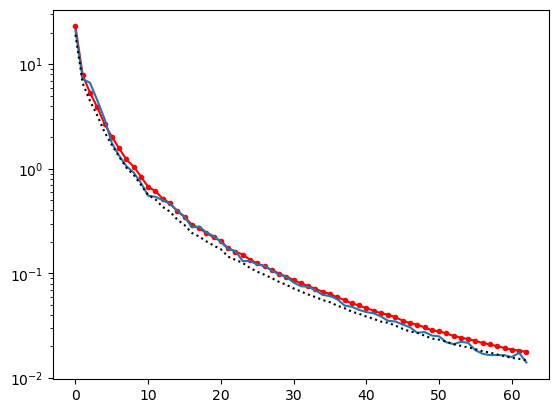

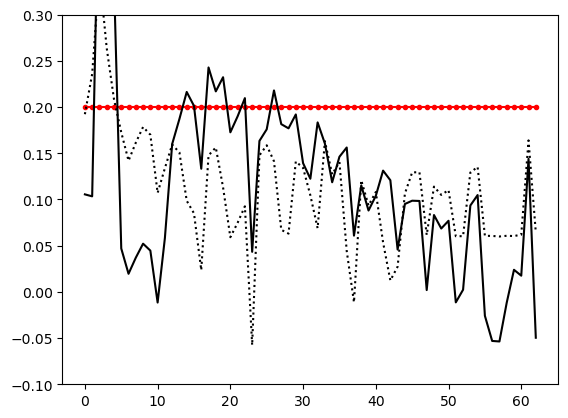

step: 5 0.40725312499999994


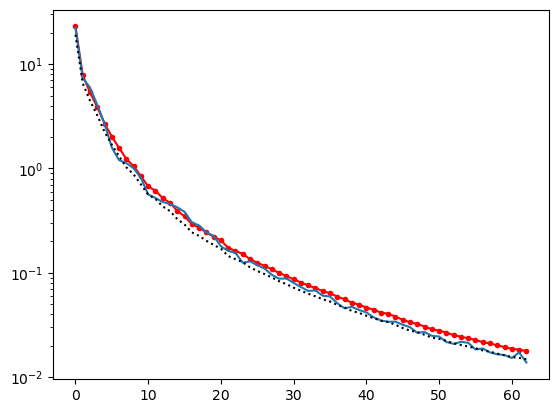

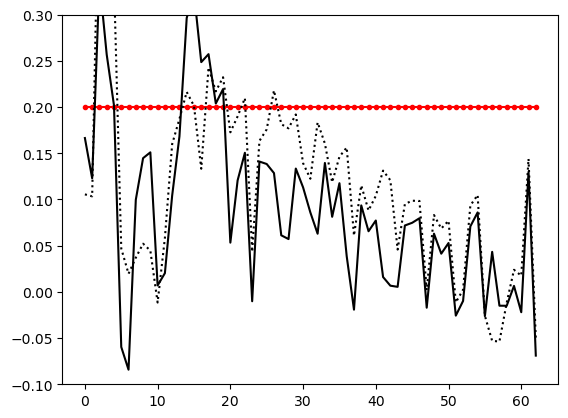

step: 6 0.38689046874999994


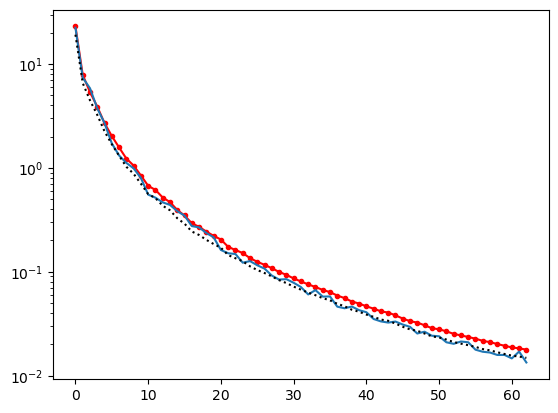

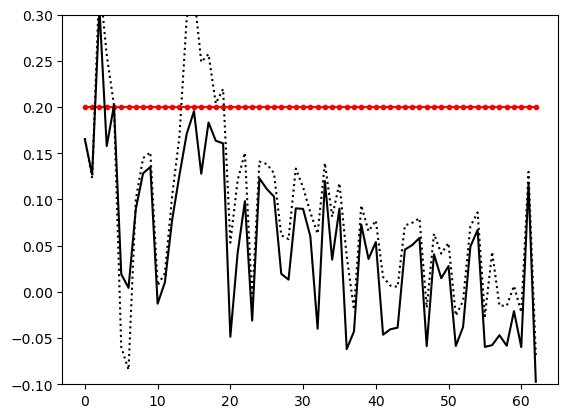

step: 7 0.3675459453124999


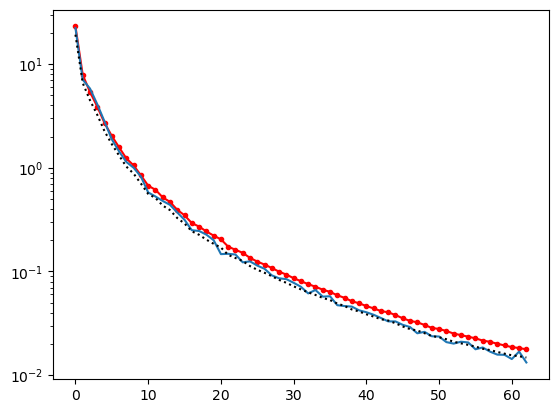

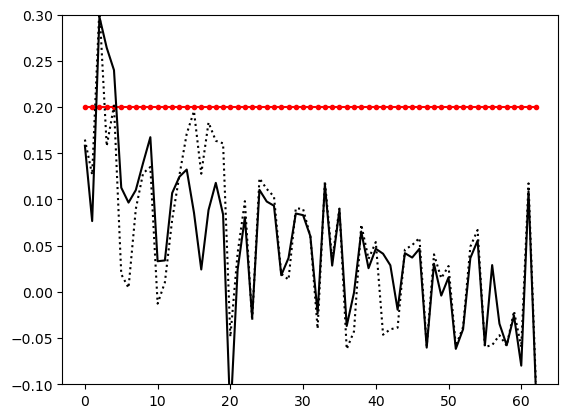

step: 8 0.34916864804687486


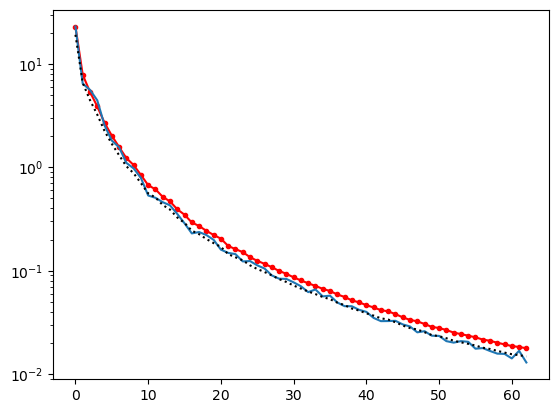

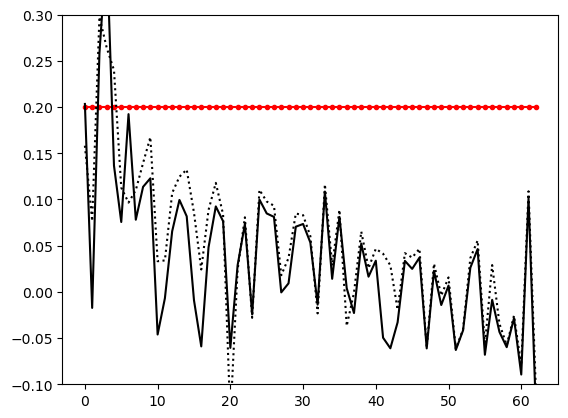

step: 9 0.3317102156445311


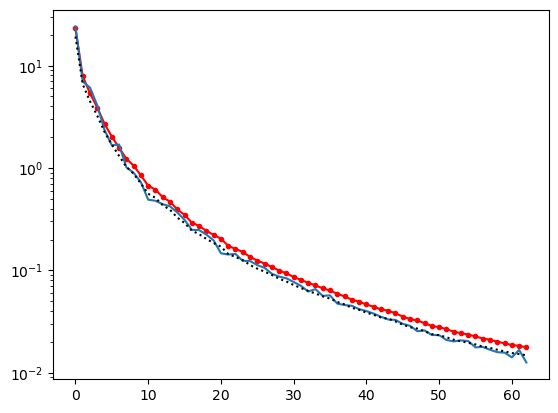

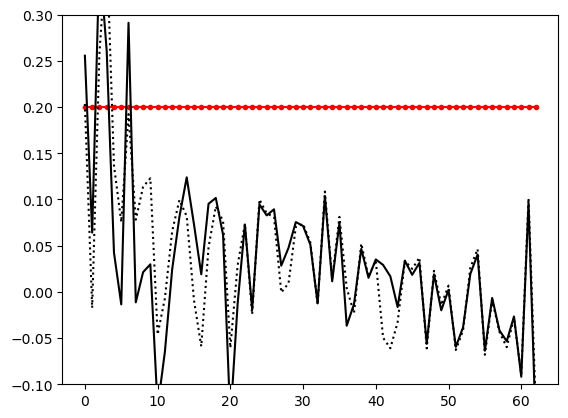

step: 10 0.31512470486230454


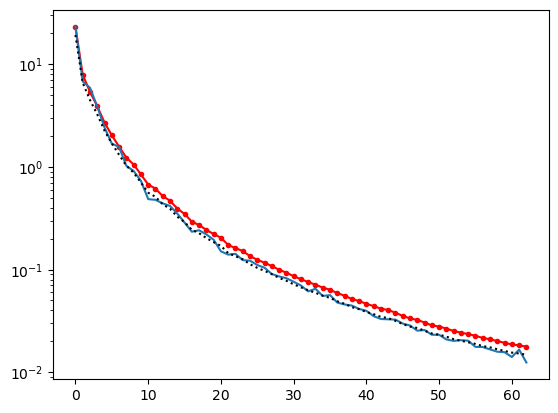

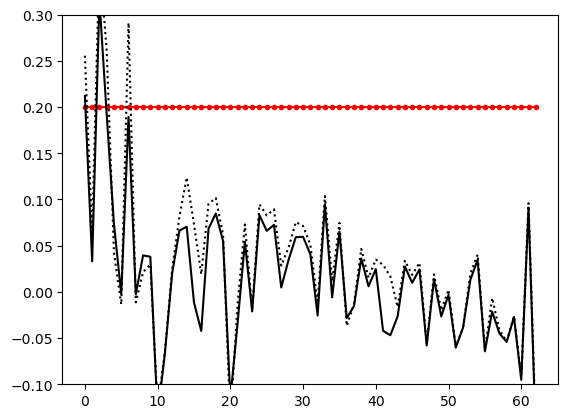

step: 11 0.2993684696191893


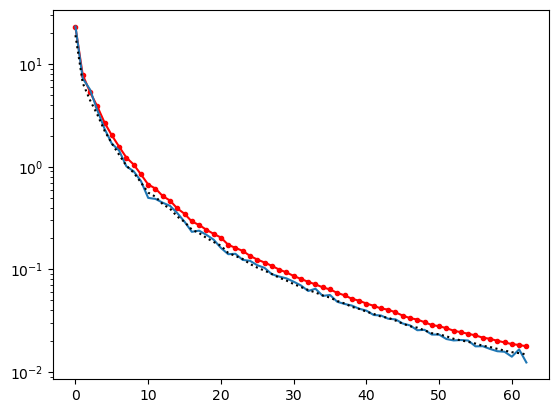

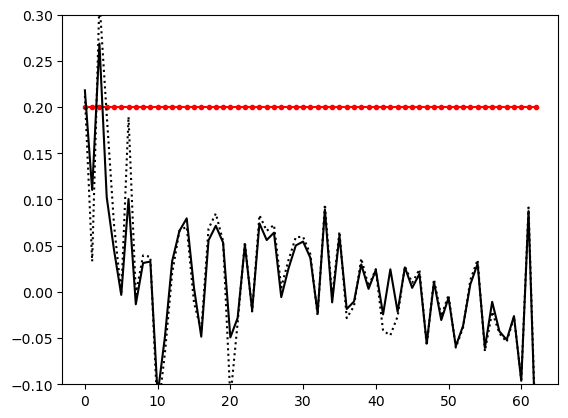

step: 12 0.2844000461382298


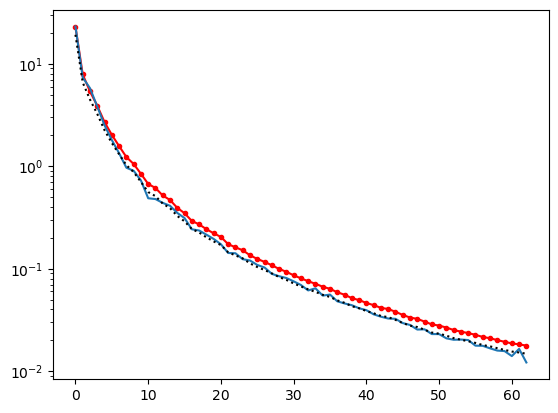

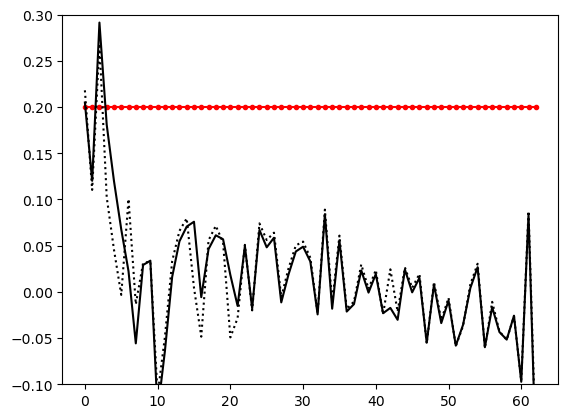

step: 13 0.2701800438313183


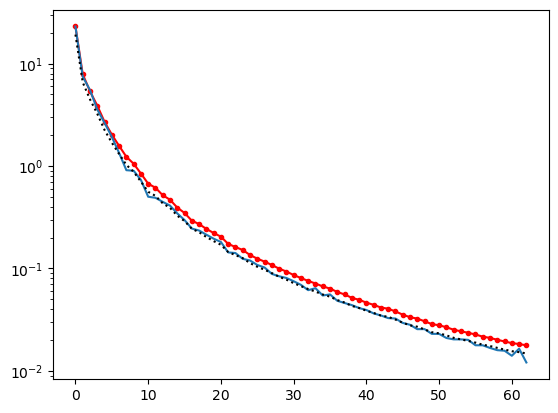

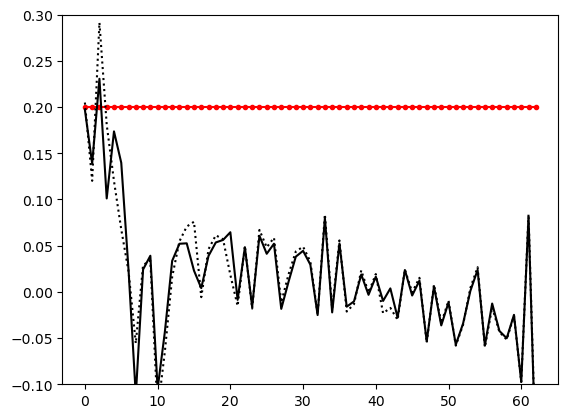

step: 14 0.25667104163975235


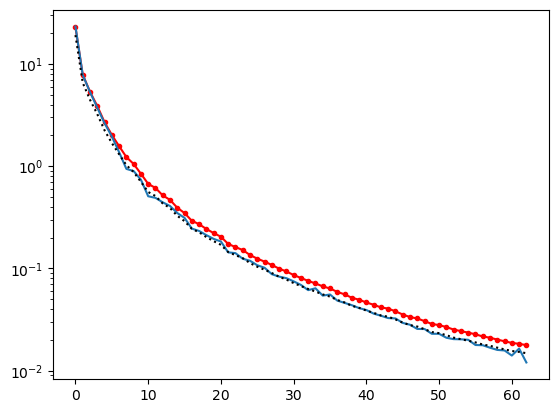

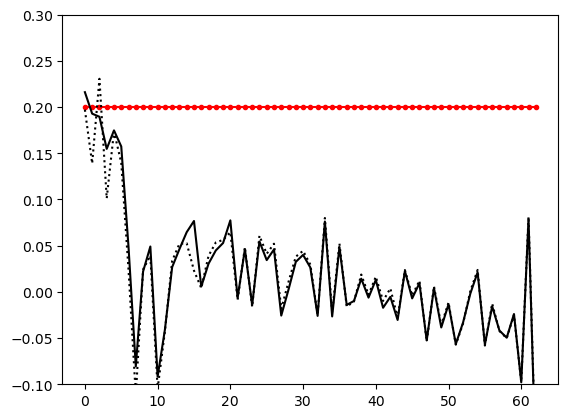

step: 15 0.24383748955776471


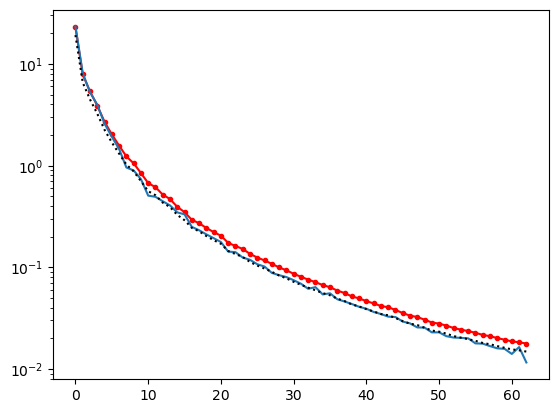

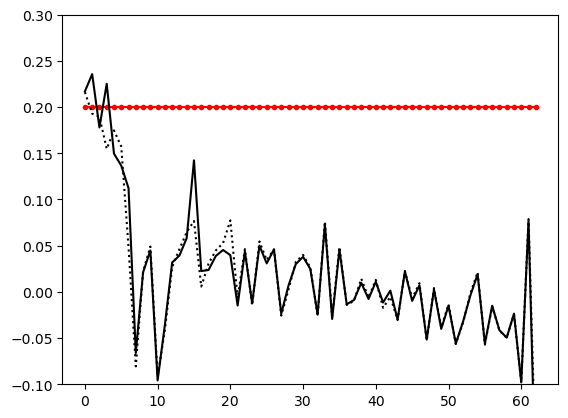

step: 16 0.23164561507987647


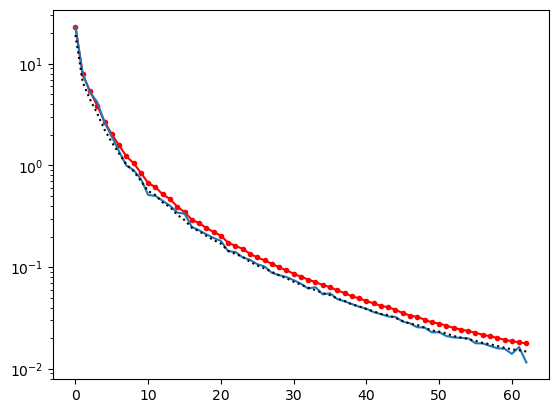

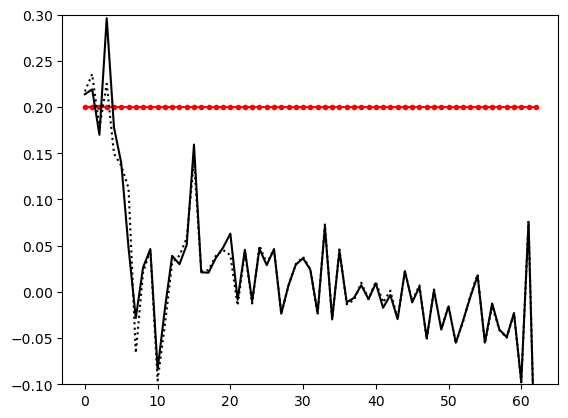

step: 17 0.22006333432588263


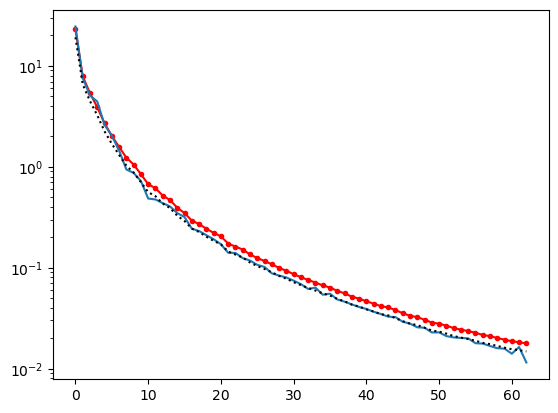

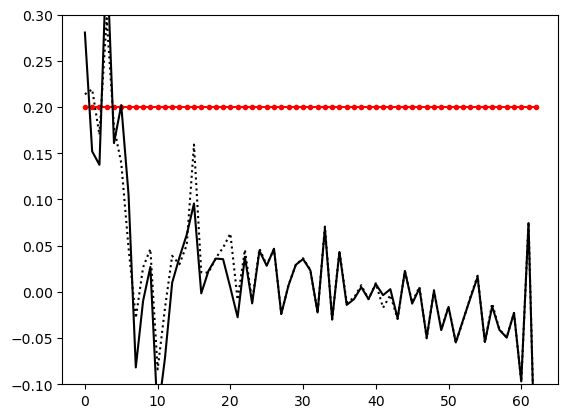

step: 18 0.20906016760958848


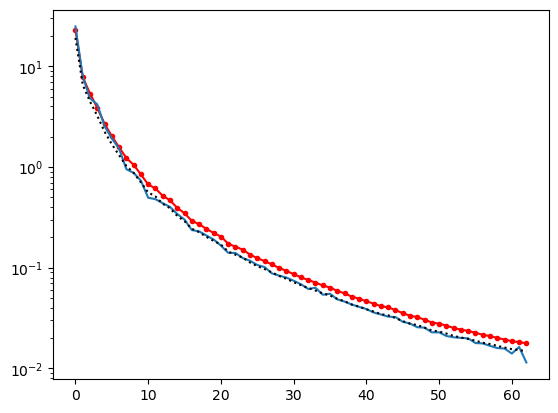

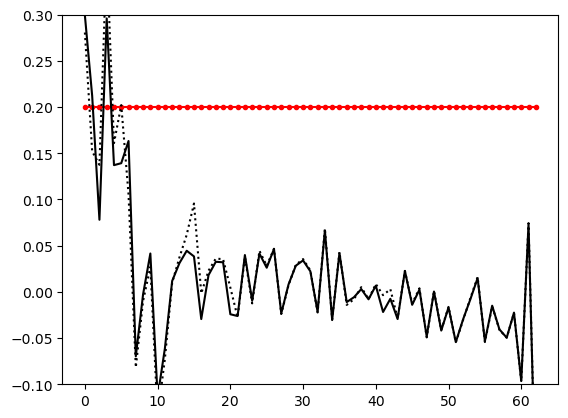

step: 19 0.19860715922910904


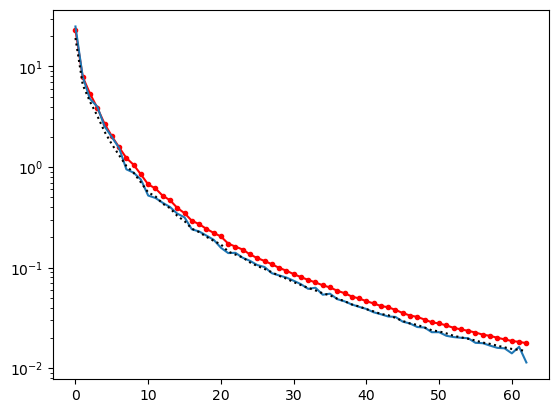

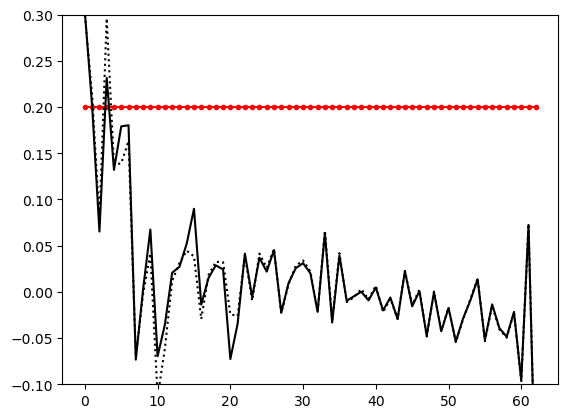

step: 20 0.18867680126765357


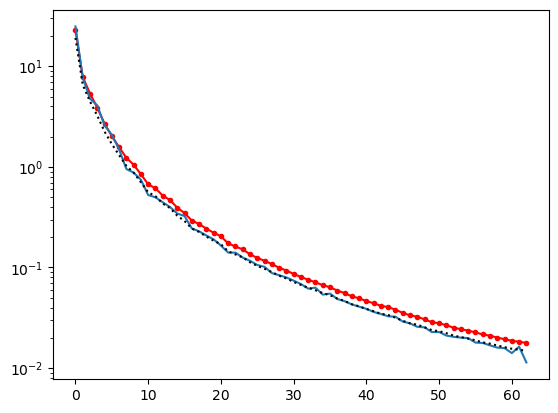

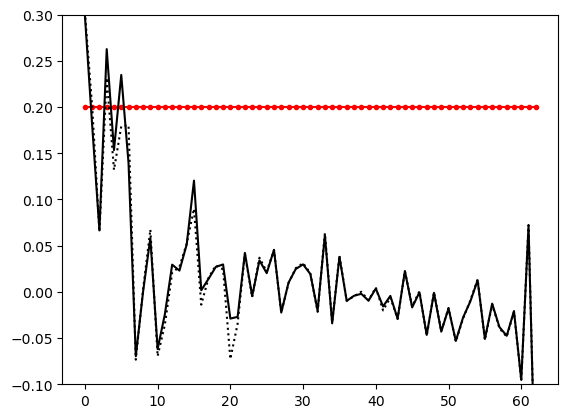

step: 21 0.17924296120427088


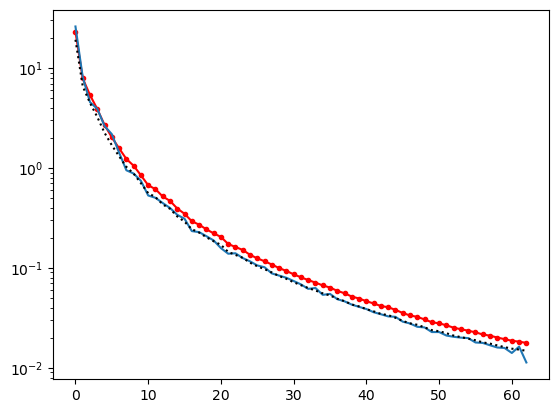

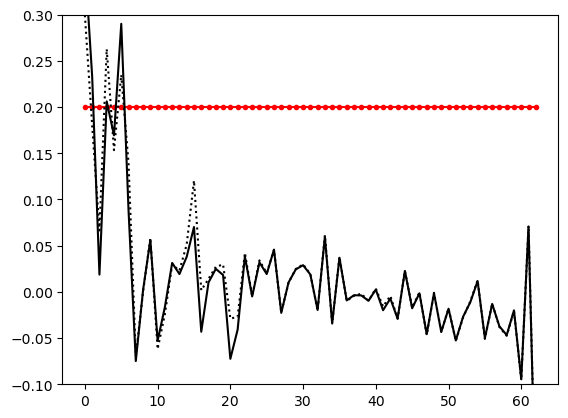

step: 22 0.17028081314405732


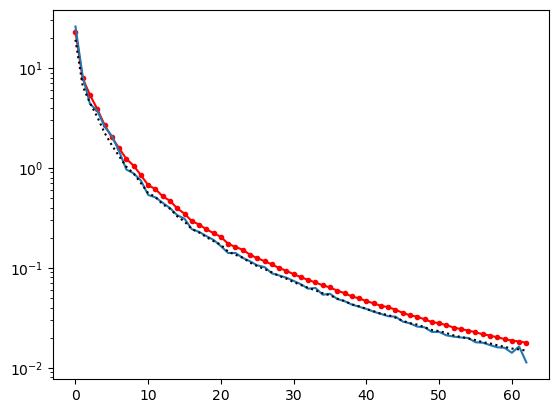

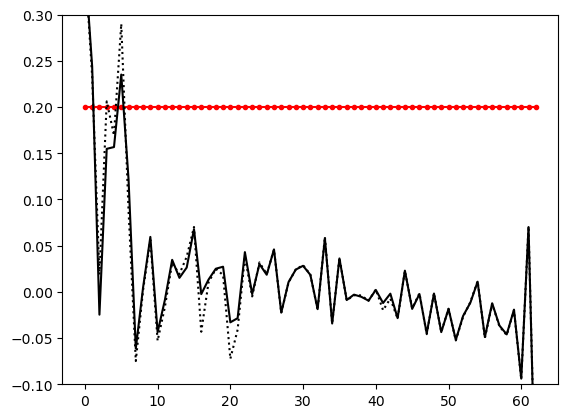

step: 23 0.16176677248685445


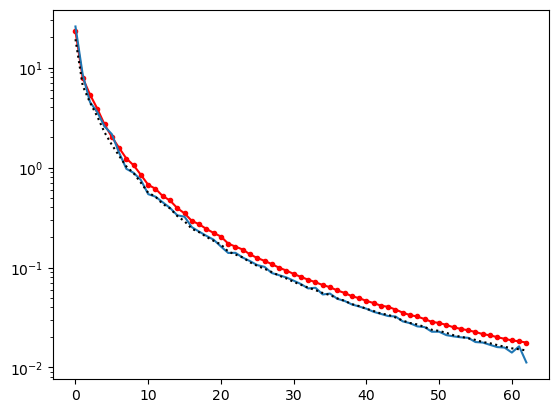

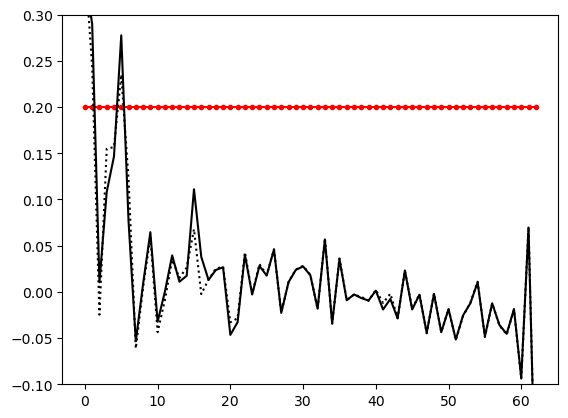

step: 24 0.15367843386251173


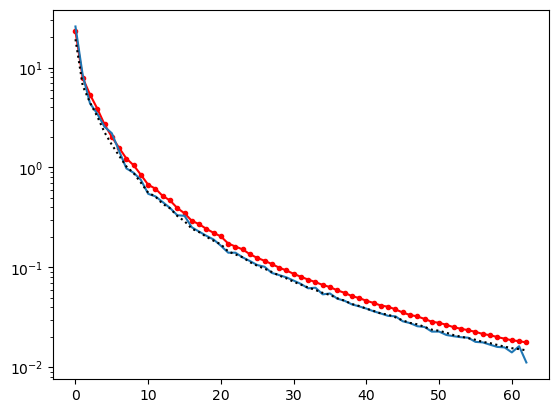

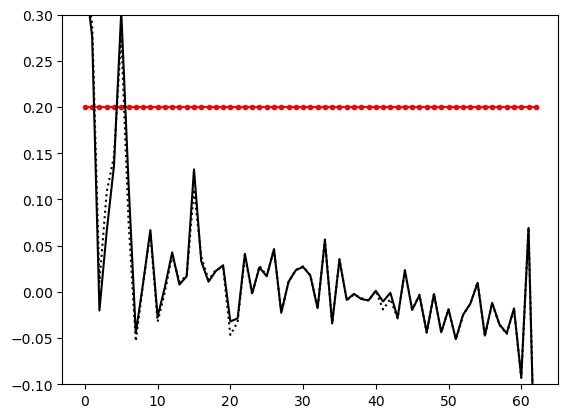

step: 25 0.14599451216938614


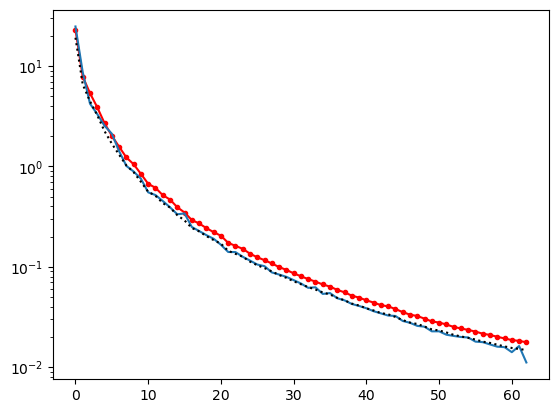

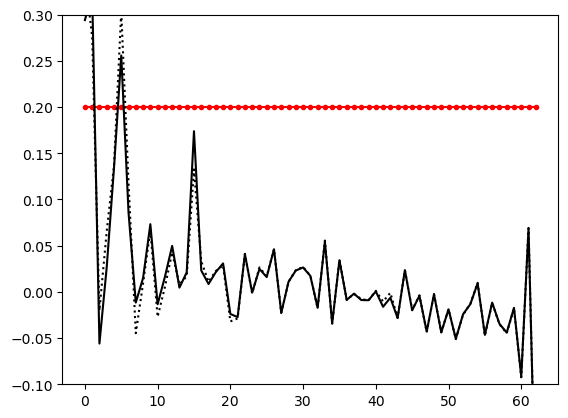

step: 26 0.13869478656091683


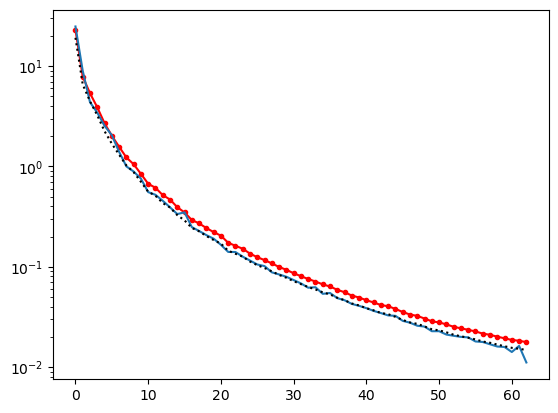

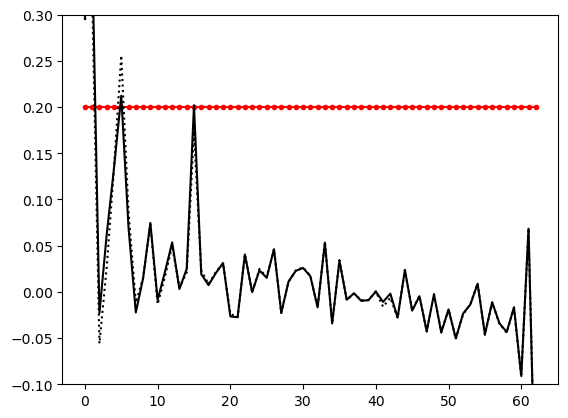

step: 27 0.131760047232871



KeyboardInterrupt



In [76]:
from datetime import datetime, timedelta
from jax.scipy.optimize import minimize

from multiprocessing.pool import ThreadPool as Pool 
pool = Pool() #jax pmap? check re-compilation times?
pmap = pool.map

#method = 'L-BFGS-B'
method = "l-bfgs-experimental-do-not-rely-on-this"
θ_rtol = 1e-5
z_rtol = 1e-5

θ_tol = 1e-5
z_tol = 1e-6

history = []
α=0.5
beta = 0.25

θ̃ = start_point
θ = start_point# if result.θ is not None else θ_start)
θL = start_point
Nθ = len(ravel_θ(θ̃))
time = timedelta(0)
for i in range(1, maxsteps+1):
        print("step:",i,α)
        t0 = datetime.now()

        if i > 1:
            xs = [x_data] + [prob.sample_x_z(_rng, θ)[0] for _rng in _split_rng(rng,nsims)]
            θ_tol = np.sqrt(-np.diag(H̃_inv_post)) * θ_rtol

        if i > 2:
            Δθ̃ = ravel_θ(history[-1]["θ̃"])- ravel_θ(history[-2]["θ̃"])
          #  if np.sqrt(-np.inner(Δθ̃, np.inner(np.linalg.pinv(history[-1]["H̃_inv_post"]), Δθ̃))) < θ_rtol:
           #     break

        # MUSE gradient
        def get_MAPs(x_z):
            x, ẑ_prev = x_z
            result = prob.z_MAP_and_score(x, ẑ_prev, θ, method=method, z_tol=z_tol, θ_tol=θ_tol)
            return result

        MAPs = list(pmap(get_MAPs, zip(xs, ẑs)))

        ẑs = [MAP.z for MAP in MAPs]
   #     if save_MAP_history:
    #        MAP_history_dat, *MAP_history_sims = [MAP.history for MAP in MAPs]
        s_MAP_dat, *s_MAP_sims = [MAP.s for MAP in MAPs]
        s̃_MAP_dat, *s̃_MAP_sims = [MAP.s̃ for MAP in MAPs]
        s̃_MUSE = unravel_θ(ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        s̃_prior, H̃_prior = gradθ_hessθ_logPrior(θ̃, transformed_θ=True)
        s̃_post = unravel_θ(ravel_θ(s̃_MUSE) + ravel_θ(s̃_prior))

        H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
       # try:
        H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        #except:
        #    print("error on Hessian inversion calc, prior ignored and trying again...")
       # H̃_inv_post = H̃_inv_like_sims
        t = datetime.now() - t0
        time += t

        history.append({
            "t":t, "θ̃":θ̃, "θ":θ,
            "s_MAP_dat": s_MAP_dat, "s_MAP_sims": s_MAP_sims,
            "s̃_MAP_dat": s̃_MAP_dat, "s̃_MAP_sims": s̃_MAP_sims, 
            "s̃_MUSE": s̃_MUSE,
            "s̃_prior": s̃_prior, "s̃_post": s̃_post, 
            "H̃_inv_post": H̃_inv_post, "H̃_prior": H̃_prior, 
            "H̃_inv_like_sims": H̃_inv_like_sims,
            "θ_tol": θ_tol,
        #    "MAP_history_dat": MAP_history_dat, 
         #   "MAP_history_sims": MAP_history_sims,
        })
        θ̃update = np.clip((np.inner(H̃_inv_post, ravel_θ(s̃_post))),-ravel_θ(θ̃)*beta,ravel_θ(θ̃)*beta)
        θ̃ = unravel_θ(ravel_θ(θ̃) - α * θ̃update)
        θ = θ̃
        #print(θ)
        if i%1==0:
            plt.semilogy(start_point,"r.-")
            plt.plot(θ)
            plt.plot(tf_cut_flat,"k:")
            plt.show()
            
            
            plt.plot((start_point-tf_cut_flat)/tf_cut_flat,"r.-")
            plt.plot((θ-tf_cut_flat)/tf_cut_flat,"k")
            plt.plot((θL-tf_cut_flat)/tf_cut_flat,"k:")
    
            plt.ylim([-.1,.3])
            plt.show()
            
            θL = θ
            #LR decay
            α *= 0.95

In [77]:
#as you can see, convergence properties are wonky, takes a bit of time to start moving... 
#Should converge if you have the patients to let it run a couple of hours


In [78]:
#Now lets try to calculate the covariance! :D

In [123]:
s_MAP_sims = history[-1]["s_MAP_sims"]
_, *z_MAP_sims = ẑs

In [124]:
len(z_MAP_sims)

5

In [125]:
def z_MAP_guess_from_truth(x, z, θ):
        return unravel_z(0 * ravel_z(z))
    
nsims = 3
    
def get_J(
        result = None,
        θ = None,
        θ_tol = None,
        z_tol = None,
        method = None,
        rng = None,
        nsims = nsims, 
        pmap = map,
        progress = False, 
        skip_errors = False,
    ):

        nsims_remaining = nsims 

        if nsims_remaining > 0:
            print(nsims_remaining)
            t0 = datetime.now()

            def get_s_MAP(rng):
                    (x, z) = prob.sample_x_z(rng, θ)
                    z_MAP_guess = prob.z_MAP_guess_from_truth(x, z, θ)
                    return prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).s
                

            rngs = _split_rng(rng, nsims_remaining)
            s_MAP_sims.extend(s for s in pmap(get_s_MAP, rngs) if s is not None)

#            time += datetime.now() - t0

        J = np.atleast_2d(np.cov(np.stack(list(map(ravel_θ, s_MAP_sims))), rowvar=False))
        return J



In [126]:
J = get_J(rng=rng,θ =θ,method=method, θ_tol=θ_tol, z_tol=z_tol)

3


In [127]:
Hs = []

In [128]:
def pjacobian(f, x, step, pmap=map, pbar=None):
    print(step,x)
    step = step + np.array(0 * x) # make array if scalar

    def column(i):
    
        def v(ε):
            ε_vec = np.array(0 * x)
            ε_vec[i] = ε
            v = f(x + ε_vec)
            if pbar: pbar.update()
            return v

        return (v(step[i]) - v(-step[i])) / (2 * step[i])

    return np.array(list(pmap(column, range(len(x)))))

In [129]:
len(z_MAP_sims)

5

In [130]:
#This takes a while, roughly an hour or two... Can probably parallelize it across GPUs if you want.

from tqdm import tqdm
from jax.scipy.sparse.linalg import cg

step = None
skip_errors = False
def _get_H_i_old(rng, z_MAP_guess_fid, *, θ, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):
    
    # for each sim, do one fit at fiducial which we'll
    # reuse as a starting point when fudging θ by +/-ϵ
    θfid = θ
    (x, z) = prob.sample_x_z(rng, θfid)
    if z_MAP_guess_fid is None:
        z_MAP_guess = _MAP_guess_from_truth(x, z, θfid)
        z_MAP_guess_fid = z_MAP_and_score(x, z_MAP_guess, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).z

    def get_s_MAP(θvec):
        θ = unravel_θ(θvec)
        (x, _) = prob.sample_x_z(copy(rng), θ)
        return ravel_θ(prob.z_MAP_and_score(x, z_MAP_guess_fid, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).s)

    return pjacobian(get_s_MAP, ravel_θ(θfid), step)


def _get_H_i(rng, z_MAP, *, θ, implicit_diff_cgtol=1e-3, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):

        #implicit implementation..
        cg_kwargs = dict(tol=implicit_diff_cgtol)

        (x, z) = prob.sample_x_z(rng, θ)
        if z_MAP is None:
            z_MAP_guess = z_MAP_guess_from_truth(x, z, θ)
            z_MAP = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).z

        θ_vec, z_MAP_vec = ravel_θ(θ), ravel_z(z_MAP)
        #unravel_θ, unravel_z = unravel_θ, unravel_z

        # non-implicit-diff term
        H1 = jacfwd(
            lambda θ1: grad(
                lambda θ2: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], z_MAP, unravel_θ(θ2))
            )(θ_vec)
        )(θ_vec)

        # term involving dzMAP/dθ via implicit-diff (w/ conjugate-gradient linear solve)
        dFdθ = jacfwd(
            lambda θ: grad(
                lambda z: prob.logLike(x, unravel_z(z), unravel_θ(θ))
            )(z_MAP_vec)
        )(θ_vec)
        dFdθ1 = jacfwd(
            lambda θ1: grad(
                lambda z: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], unravel_z(z), θ)
            )(z_MAP_vec)
        )(θ_vec)
        inv_dFdz_dFdθ1 = vmap(
            lambda vec: cg(
                lambda vec: jvp(lambda z: grad(lambda z: prob.logLike(x, unravel_z(z), θ))(z), (z_MAP_vec,), (vec,))[1], 
                vec, 
                **cg_kwargs
            )[0], 
            in_axes=1, out_axes=1
        )(dFdθ1)
        H2 = -dFdθ.T @ inv_dFdz_dFdθ1
        return H1 + H2

Hs = []

nsims_remaining = 1  #- len(result.Hs)

z_MAP_sims = z_MAP_sims

if nsims_remaining > 0:
    print(nsims_remaining)
    # default to finite difference step size of 0.1σ with σ roughly
    # estimated from s_MAP_sims sims, if we have them
    if step is None:
        if len(s_MAP_sims) > 0:
            step = 0.1 / np.std(np.stack(list(map(ravel_θ, s_MAP_sims))), axis=0)
        else:
            step = 1e-5
    
    Nθ = len(ravel_θ(θ))
    pbar = partial(tqdm, total=nsims_remaining, desc="get_H", disable=(True))

    t0 = datetime.now()
    rngs = _split_rng(rng, nsims)[-nsims_remaining:]
    z_MAP_sims = (z_MAP_sims + [None]*(max(0, nsims - len(z_MAP_sims))))[-nsims_remaining:]
    _get_H_ii = partial(_get_H_i, θ=θ, method=method, θ_tol=θ_tol, z_tol=z_tol, step=step, skip_errors=skip_errors)
    Hs.extend(H for H in pbar(map(lambda args: _get_H_ii(*args), zip(rngs, z_MAP_sims)) )if H is not None)
   # result.time += datetime.now() - t0

avg = np.mean#np.median if use_median else np.mean
H = avg(np.array(Hs), axis=0)

1


AxisError: axis -2 is out of bounds for array of dimension 0

In [ ]:
Hs[0]

In [ ]:
import scipy as sp

Nθ = len(ravel(θ))

H_prior = -ravel(prob.gradθ_hessθ_logPrior(θ, transformed_θ=False)[1]).reshape(Nθ,Nθ)
Σ_inv = H.T @ np.linalg.pinv(J) @ H + H_prior
Σ = np.linalg.pinv(Σ_inv)
try:
    if θ is not None:
        if Nθ == 1:
            dist = sp.stats.norm(ravel(θ), np.sqrt(Σ[0,0]))
        else:
            dist = sp.stats.multivariate_normal(ravel(θ), Σ)
except:
    print("likely error in covariance... proceed with caution!")

In [ ]:
plt.plot(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.sqrt(np.diag(Σ))/tf_cut_flat)

plt.plot(abs((start_point-θ)/tf_cut_flat),"k:")

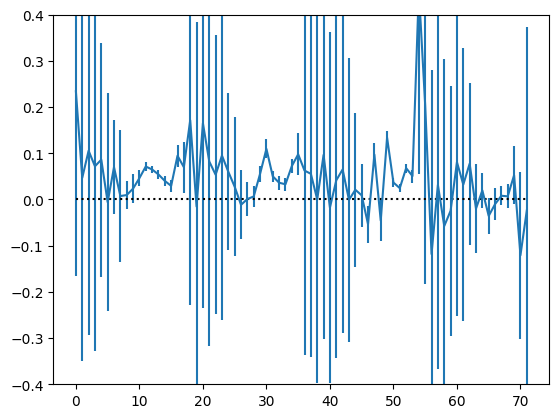

In [33]:
#need to run optimization for longer, since thsoe smaller scale modes in each mu-bin are not converged...
plt.errorbar(np.arange(len(tf_cut_flat)),(θ-tf_cut_flat)/tf_cut_flat,yerr=1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.arange(len(tf_cut_flat)),np.arange(len(tf_cut_flat))*0.0,"k:")
plt.ylim(-0.4,0.4)
plt.show()

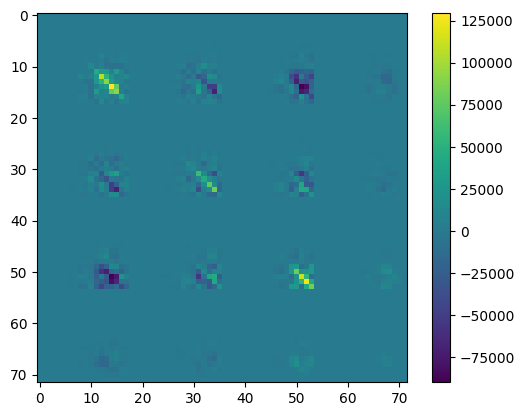

In [34]:
imshow(Σ_inv)
colorbar()